In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as cl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import os
from io import StringIO
from scipy.optimize import curve_fit 
plt.rcParams["figure.figsize"] = (8, 4.5)


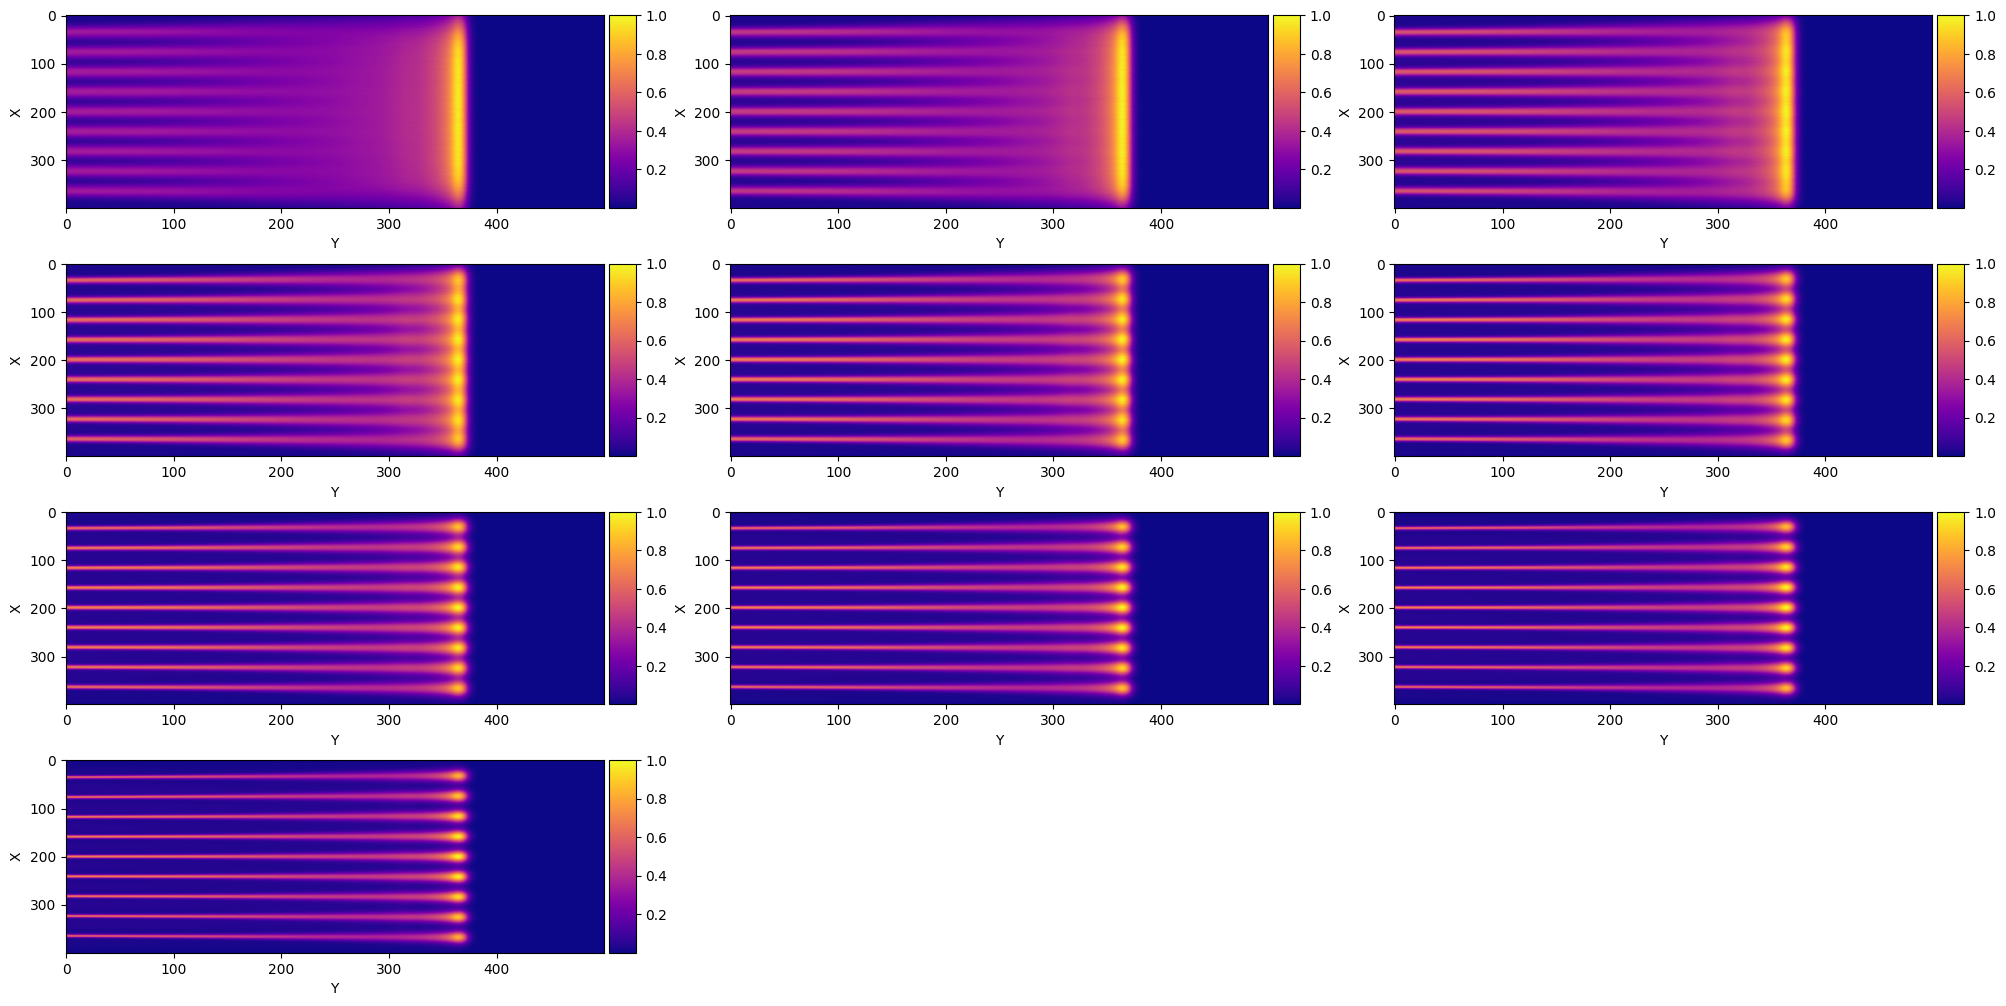

In [3]:
files_cut = []
nums = [3,4,5,6,7,8,9,10,11,12]
N = len(nums)

for i in nums:
    files_cut.append("results/dose_cut_xz_"+str(i)+".csv")
    files_cut.append("results/dose_cut_xz_"+str(i)+"_1.csv")
    files_cut.append("results/dose_cut_xz_"+str(i)+"_2.csv")
    files_cut.append("results/dose_cut_xz_"+str(i)+"_3.csv")
    files_cut.append("results/dose_cut_xz_"+str(i)+"_4.csv")
    files_cut.append("results/dose_cut_xz_"+str(i)+"_5.csv")
    files_cut.append("results/dose_cut_xz_"+str(i)+"_6.csv")

df_cut = pd.DataFrame()

for f in files_cut:
    df_cut = pd.concat((df_cut, pd.read_csv(f, skiprows=8 , header=None, dtype = 'float16')), ignore_index=True)


dist = np.reshape(df_cut[3], (len(nums),int(len(files_cut)/len(nums)),400,500))
del df_cut

dist = np.sum(dist, axis=1)

plt.figure(figsize=(20,10))


for i in range(N):
    ax = plt.subplot(4,3,i+1)
    ax = plt.gca()
    im = ax.imshow(np.fliplr(dist[i]/np.max(dist[i])),aspect='auto' ,  cmap='plasma')
    plt.xlabel("Y")
    plt.ylabel("X")
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
   
    plt.colorbar(im, cax=cax)
    
    

plt.tight_layout(pad = 0.5)
plt.savefig("../def/images/spessore_cut.png")
plt.show()


In [4]:
pvdr_plot = []

def gauss(x, off, A, mu, sigma): 
    return off + A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def lin(x, a, b):
    return a*x + b

nf = int(20)
N = len(nums)

for i in range(N):
    data = np.fliplr(dist[i])
    x_fit = np.linspace(-(nums[i])/6,(nums[i])/6,2*nf)
    x_len = np.linspace(-5*nums[i],5*nums[i],10000)
    y_fit = data[200-nf:200+nf,5]
    
    p_fit, p_cov = curve_fit(gauss, x_fit, y_fit, maxfev=10000, p0=[0, 1, 0, 0.5])
    x_cont = np.linspace(-nums[i]/6,nums[i]/6,1000)
    fit = gauss(x_cont, *p_fit)
    pvdr_plot.append(np.max(fit)/np.min(fit))
    # plt.plot(x_fit, y_fit, '.')
    # plt.plot(x_cont, fit, label='fit')
    # #plt.plot(x_len, data[:,i])
    # #plt.xlim(-2,2)
    # plt.grid()
    # plt.show()


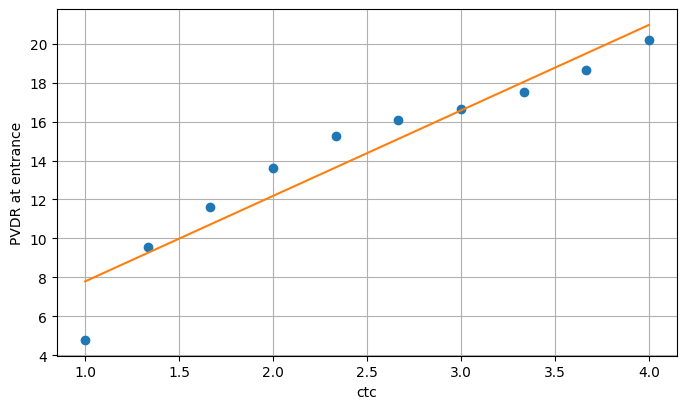

In [5]:
numsp = np.array(nums)/3
x_pl = np.linspace(1,4,1000)

p_fitl, p_covl = curve_fit(lin, numsp, pvdr_plot)
lin_pv = lin(x_pl, *p_fitl)

plt.plot(numsp,pvdr_plot, 'o')
plt.plot(x_pl, lin_pv, label='fit')
plt.xlabel("ctc")
plt.ylabel("PVDR at entrance")
plt.grid()

In [6]:
d = int(16)
nf = int(15)
step = int(25)
limit = 1.05

pvdr_fit = np.ones((N,d))**2

for j in range(1,N):
    dose = np.fliplr(dist[j])
    x_fit = np.linspace(-nums[j]/6,nums[j]/6,2*nf)
    x_cont = np.linspace(-nums[j]/6,nums[j]/6,1000)
    for i in range(0,d):
        if i == 0:
            data = dose[:,i*step]
            y_fit = data[200-nf:200+nf]
            p_fit, p_cov = curve_fit(gauss, x_fit, y_fit, maxfev = 10000)
            fit = gauss(x_cont, *p_fit)
            pvdr_fit[j,i] = np.max(fit)/np.min(fit)
            # plt.plot(x_fit, y_fit, '.')
            # plt.plot(x_cont, fit, label='fit')

        if pvdr_fit[j,i-1] > limit and i > 0:
            data = dose[:,i*step]
            y_fit = data[200-nf:200+nf]
            p_fit, p_cov = curve_fit(gauss, x_fit, y_fit, maxfev=10000)
            fit = gauss(x_cont, *p_fit)
            pvdr_fit[j,i] = np.max(fit)/np.min(fit)
            # plt.plot(x_fit, y_fit, '.')
            # plt.plot(x_cont, fit, label='fit')

        if pvdr_fit[j,i-1] < limit and i > 0:
            pvdr_fit[j,i] = 1
        
        

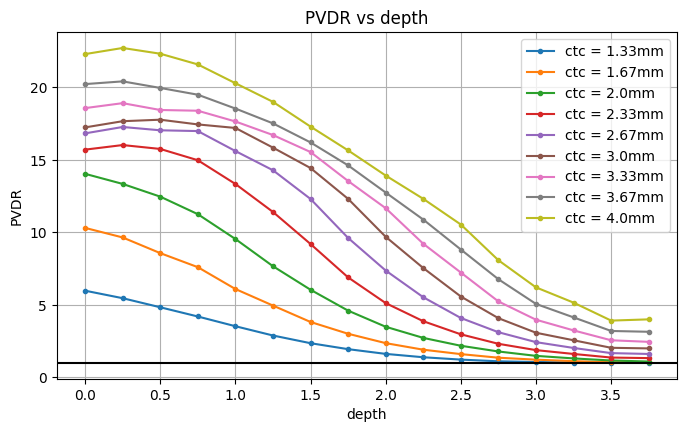

In [7]:
legend = []
z_plot = np.linspace(0,5*(step*d-step)/500,d)

for i in range(1,N):
    plt.plot(z_plot,pvdr_fit[i,:], '.-')
    legend.append('ctc = ' + (str(np.round(numsp[i], 2))) + 'mm')
plt.axhline(y=1, color='k', linestyle='-')
plt.grid()
plt.xlabel("depth")
plt.legend(legend)
plt.ylabel("PVDR")
plt.title("PVDR vs depth")
plt.savefig("../def/images/PVDR_density.png")
plt.show()